Prioritised Double Deep Q-Learning for Atari Breakout

In [1]:
#Many imports
import retro
import numpy as np
from queue import Queue
import cv2
import itertools
from retro.examples.discretizer import Discretizer
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
from matplotlib import pyplot as plt
from operator import itemgetter 
import GPUtil

In [2]:
class Env_Wrap:
    def __init__(self, state_len, num_frame_skip):
        #Initiate Environment Wrapper
        self.env = retro.RetroEnv(game='Breakout-Atari2600')
        
        # Define action space in terms of valid combinations of button presses
        combos = [['BUTTON'],['LEFT'],['RIGHT'],[]]
        self.action_space_size = len(combos)
        self.env = Discretizer(self.env, combos=combos)
        
        #Number of frames to skip
        self.num_frame_skip = num_frame_skip 
        self.num_frame_skip_1 = num_frame_skip - 3
        
        #Number of frames in each state
        self.state_len = state_len
        
        _ = self.reset()
        
    def reset(self):
        #Frame buffer
        self.frame_buffer = np.zeros((80,80,2))
        
        #Hold the previous 4 states
        self.state_queue = Queue(maxsize = self.state_len)
        #Fill state queue with empty states
        for i in range(self.state_len):
            self.state_queue.put(np.zeros((80,80)))
        
        self.env.reset()
        #Take NOOP action 
        for _ in range(15):
            state,_,_,_ = self.step(3)
        
        return state
        
    def step(self, action):
        
        next_step, reward, terminal, info = self.frame_skip(action)
        _ = self.state_queue.get()
        self.state_queue.put(next_step)
        state = np.stack(list(self.state_queue.queue)).astype(np.uint8)
        
        return state, reward, terminal, info
    
    def render(self):
        self.env.render()
        
    def close(self):
        self.env.close()
    
    def frame_skip(self, action):
        
        total_reward = 0.0
        for skip in range(self.num_frame_skip):
        
            if skip > self.num_frame_skip_1:
                obs, rew, done, info = self.env.step(action)
                self.frame_buffer[:,:,skip-(self.num_frame_skip-2)] = self.grayscale_downsample_crop(obs)
            
            else:
                obs, rew, done, info = self.env.step(action)
                
            total_reward += rew
        
        max_pool = np.maximum(self.frame_buffer[:,:,0],self.frame_buffer[:,:,1])
        
        return max_pool, total_reward, done, info
    
    def grayscale_downsample_crop(self, frame):
        #Frames are coverted to gray scale, downsampled by 50% and cropped to 80x80 
        
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        (oldh, oldw, oldc) = self.env.observation_space.shape
        ratio = 2
        newshape = (oldw//ratio, oldh//ratio)
        
        downsampled_gray_frame = cv2.resize(gray_frame, newshape, interpolation=cv2.INTER_AREA)
        
        grayscale_downsample_crop_frame = downsampled_gray_frame[20:100,:]
        
        return grayscale_downsample_crop_frame

Run a random agent on the environment.

In [3]:
class Random_Agent():
    def __init__(self):
        pass

    def select_action(self):
        return env_wrap.env.action_space.sample()  # sample random action

random_agent = Random_Agent()

In [4]:
N = 10
max_time_steps = 200
env_wrap = Env_Wrap(4,4)

#run the random agent in the environment for N episodes
for episode in range(N):
    reward_sum = 0
    next_state = env_wrap.env.reset()
    for i in range(max_time_steps):
        action = random_agent.select_action()
        next_state, reward, terminal, info = env_wrap.step(action)
        reward_sum += reward
        #env_wrap.render()
        if terminal:
            clear_output(wait=True)
            time.sleep(0.2)
            print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
            break
print('episode:', episode, 'sum_of_rewards_for_episode:', reward_sum)
#env_wrap.env.render(close=True)

episode: 9 sum_of_rewards_for_episode: 0.0
episode: 9 sum_of_rewards_for_episode: 0.0


Constructing the Q Network

In [5]:
state_dim = 4
action_dim = env_wrap.env.action_space.n

print('Number of observations for a given state:', state_dim)
print('Number of actions for a given state:', action_dim)

Number of observations for a given state: 4
Number of actions for a given state: 4


In [6]:
#Larger network used in nature paper 
class Q_Network(nn.Module):
    def __init__(self, state_dim , action_dim):
        super(Q_Network, self).__init__()
        self.x_layer = nn.Conv2d(state_dim,32,8,stride=4) #convolves 32 filters of 8 x 8 with stride 4
        nn.init.kaiming_normal_(self.x_layer.weight, mode='fan_in', nonlinearity='relu') #He (2015) initialization
        self.h_layer1 = nn.Conv2d(32,64,4,stride=2) #convolves 64 filters of 4 x 4 with stride 2
        nn.init.kaiming_normal_(self.h_layer1.weight, mode='fan_in', nonlinearity='relu')
        self.h_layer2 = nn.Conv2d(64,64,3,stride=1) #convolves 64 filters of 3 x 3 with stride 1
        nn.init.kaiming_normal_(self.h_layer2.weight, mode='fan_in', nonlinearity='relu')
        self.h_layer3 = nn.Linear(6*6*64,512) #512 rectifier units
        nn.init.kaiming_normal_(self.h_layer3.weight, mode='fan_in', nonlinearity='relu')
        self.y_layer = nn.Linear(512, action_dim) #fully-connected linear layer with a single output for each action

    def forward(self, x):
        x = x/255.0
        x = F.relu(self.x_layer(x))
        x = F.relu(self.h_layer1(x))
        x = F.relu(self.h_layer2(x))
        x = F.relu(self.h_layer3(x.view(-1,6*6*64)))
        x = self.y_layer(x)
        return x

In [7]:
#Test network gives the correct output
qnet = Q_Network(state_dim, action_dim)
state = torch.from_numpy(env_wrap.reset()).float().view(-1,4,80,80)
q_values = qnet(state)
print('output of our q_network given a state input: ', q_values)

output of our q_network given a state input:  tensor([[-0.0152,  0.1620, -0.0772,  0.1325]], grad_fn=<AddmmBackward>)


Construct the Replay Buffer

In [8]:
class SumTree(object):

    def __init__(self, replay_size):

        self.replay_size = replay_size
        self.priority_size = 2*replay_size - 1
        self.priority = [0.0 for _ in range(2*replay_size-1)]
        #self.priority = torch.zeros(self.priority_size, dtype=torch.float).cuda()
        self.priority[0] = 1.0
        #self.memory = [0 for _ in range(replay_size)]
        self.states_memory = [0 for _ in range(replay_size)]
        self.next_states_memory = [0 for _ in range(replay_size)]
        self.actions_memory = [0 for _ in range(replay_size)]
        self.rewards_memory = [0 for _ in range(replay_size)]
        self.terminals_memory = [0 for _ in range(replay_size)]
        self.cursor = 0
        self.cur_size = 0

    def sum_up(self, index, delta):

        parent_ind = (index - 1) // 2

        self.priority[parent_ind] += delta

        if not self.is_root(parent_ind):
            self.sum_up(parent_ind, delta)

    def update_priority(self, index, new_priority):

        delta = new_priority - self.priority[index]

        self.priority[index] = new_priority

        self.sum_up(index, delta)

    def add_memory(self, state, next_state, action, reward, terminal, priority):

        #self.memory[self.cursor] = data
        
        self.states_memory[self.cursor] = state
        self.next_states_memory[self.cursor] = next_state
        self.actions_memory[self.cursor] = action
        self.rewards_memory[self.cursor] = reward
        self.terminals_memory[self.cursor] = terminal

        priority_index = self.cursor + (self.replay_size - 1)
        #self.priority[priority_index] = priority
        self.update_priority(priority_index, priority)

        self.cursor = (self.cursor + 1) % self.replay_size

        if self.cur_size < self.replay_size:
            self.cur_size += 1 

    def is_root(self, index):

        if index == 0:
            return True
        else:
            return False

    def priority_total(self):

        return self.priority[0]

    def get_priority(self, index, sample):

        left_child = 2*index + 1
        right_child = 2*index + 2

        if left_child >= self.priority_size:

            return index

        elif sample <= self.priority[left_child]:

            return self.get_priority(left_child, sample)

        else:

            return self.get_priority(right_child, sample - self.priority[left_child])

    def get(self, sample):

        priority_index = self.get_priority(0, sample)

        memory_index = priority_index - self.replay_size + 1

        #return priority_index, self.priority[priority_index], self.memory[memory_index]
        return priority_index, memory_index


In [9]:
class PrioritisedMemory(object):

    def __init__(self, alpha, beta, beta_end, epsilon, num_steps, replay_size):

        self.alpha = alpha
        self.beta_start = beta
        self.beta_end = beta_end
        self.beta = beta 
        self.epsilon = epsilon
        self.num_steps = num_steps

        self.memory = SumTree(replay_size)
        self.replay_size = replay_size

    def proprotional_priority(self, td_error):

        return torch.pow((torch.abs(td_error) + self.epsilon),self.alpha)

    def add_memory(self, td_error, state, next_state, action, reward, terminal):

        priority = self.proprotional_priority(td_error)

        self.memory.add_memory(state, next_state, action, reward, terminal, priority)

        self.beta = np.min([1.0, self.beta + (self.beta_end-self.beta_start)/self.num_steps])

    def update_priority(self, index, td_error):

        new_priority = self.proprotional_priority(td_error)
        self.memory.update_priority(index, new_priority)

    def minibatch_sample(self, minibatch_size):

        priority_indexes = []
        memory_indexes = []

        interval = self.memory.priority_total().item()/minibatch_size
        #print(interval)

        for i in range(minibatch_size):

            sample = np.random.uniform(i*interval, (i+1)*interval)

            priority_index, memory_index = self.memory.get(sample)

            priority_indexes.append(priority_index)
            memory_indexes.append(memory_index)
            
        states = torch.stack(itemgetter(*memory_indexes)(self.memory.states_memory))
        next_states = torch.stack(itemgetter(*memory_indexes)(self.memory.next_states_memory))
        actions = torch.stack(itemgetter(*memory_indexes)(self.memory.actions_memory))
        rewards = torch.stack(itemgetter(*memory_indexes)(self.memory.rewards_memory))
        terminals = torch.stack(itemgetter(*memory_indexes)(self.memory.terminals_memory))
        priorities = torch.stack(itemgetter(*priority_indexes)(self.memory.priority))

        sampling_probabilities = priorities/self.memory.priority_total()
        importance_weights = torch.pow(self.memory.replay_size * sampling_probabilities, -self.beta)
        importance_weights /= torch.max(importance_weights)

        return priority_indexes, states, next_states, actions, rewards, terminals, importance_weights 


DQN Agent Implementation

In [10]:
class DQNAgent(object):
    def __init__(self, state_dim, action_dim, gamma, 
                 alpha, beta, beta_end, epsilon, num_steps, 
                 replay_size, tau, learning_rate, minibatch_size):
        
        self.qnet = Q_Network(state_dim, action_dim)
        self.qnet_target = copy.deepcopy(self.qnet)
        self.discount_factor = gamma
        self.MSELoss_function = nn.MSELoss()
        self.replay_buffer = PrioritisedMemory(alpha, beta, beta_end, epsilon, num_steps, replay_size)
        self.tau = tau
        self.minibatch_size = minibatch_size
        
        if torch.cuda.is_available():
            self.qnet.cuda()
            self.qnet_target.cuda()
            print('Running model on GPU:',torch.cuda.get_device_name(torch.cuda.current_device()),'!')
        
        self.qnet_optim = torch.optim.Adam( self.qnet.parameters(), lr=learning_rate)
    
    def epsilon_greedy_action(self, state, epsilon):
        if np.random.uniform(0, 1) < epsilon:
            return env_wrap.env.action_space.sample()  # choose random action
        else:
            network_output_to_numpy = (self.qnet(state)).cpu().data.numpy()
            #network_output = self.qnet(state)
            return np.argmax(network_output_to_numpy)  # choose greedy action
            
    def update_Q_Network(self, state, next_state, action, reward, terminals, importance_weights, priority_indexes):
        qnetsa = torch.gather(self.qnet(state), dim=1, index=action.long())
        
        #YDoubleDQN_t ≡ R_t+1 + γ * Q(S_t+1, argmax_aQ(S_t+1, a; θ_t), θ^−_t).
        
        _,qnetsa_next_state_action_argmax = torch.max(self.qnet(next_state), dim=1, keepdim=True)
        qtargetsa_next_state_argmax_qnet = torch.gather(self.qnet_target(next_state), 1, qnetsa_next_state_action_argmax)
        not_terminals = 1 - terminals
        qsa_next_target = reward + not_terminals * self.discount_factor * qtargetsa_next_state_argmax_qnet 
        td_error = (qsa_next_target - qnetsa).detach()
        
        #update transition priority
        for i in range(self.minibatch_size):
            priority_index = priority_indexes[i]
            self.replay_buffer.update_priority(priority_index, td_error[i])
        
        q_network_loss = (importance_weights.detach() * self.MSELoss_function(qnetsa, qsa_next_target.detach())).mean()
        self.qnet_optim.zero_grad()
        q_network_loss.backward()
        #Gradient Clipping between (-1, 1)
        for param in self.qnet.parameters():
            param.grad.data.clamp_(-1, 1)
        self.qnet_optim.step()
        
        return q_network_loss
        
    def update(self):
        priority_indexes, states, next_states, actions, rewards, terminals, importance_weights  = self.replay_buffer.minibatch_sample(self.minibatch_size)
        
        loss = self.update_Q_Network(states, next_states, actions, rewards, terminals, importance_weights, priority_indexes)
        
        return loss.item()

Train Network

In [11]:
#Learning parameters
total_time_steps = 1100000 #Number of steps to train on
max_time_steps = 5000 #Max number of step in each episode if terminal state not reached
gamma = 0.99 #Discount factor
learning_rate = 0.00025 #Gradient step size, they used 0.00025/4 in the paper  
                        #but use 0.00025 for fairer comparison with vanilla DQN
learning_starts = 100000 #Model starts learning after x transitions
update_freq = 4 #Minibatch update frequency in number of steps

#Exploration parametrs
epsilon_start = 1.0 #Starting epsilon value
epsilon_mid = 0.1 #Epsion value after some training
epsilon_final = 0.01 #Final epsiolon value
epsilon_decay_length1 = 100000 #total_time_steps//10 #Number of episodes to decay epsilon over, 10% total time steps
epsilon_decay_length2 = total_time_steps - epsilon_decay_length1 -learning_starts
eps = epsilon_start

#Target update frequency
target_update = 10000 #Target network update frequency (number of steps)
tau = 0.001 #Soft target network update

#Prioritised Memory Parameters
alpha = 0.6
beta = 0.4
beta_end = 1.0 
epsilon = 0.01 
replay_size = 100000 #Number of transitions to store in replay memory, 10% total steps
minibatch_size = 32 #Number of samples in minibatch update, 32 used in atari DQN paper

#Create agent object
agent = DQNAgent(state_dim, action_dim, gamma, 
                 alpha, beta, beta_end, epsilon, total_time_steps, 
                 replay_size, tau, learning_rate, minibatch_size)

#Loop parameters
reward_sums = []
best_reward = -np.inf
total_steps = 0
episode = 0
reward_sum = 0
eps = epsilon_start
save_freq = 100000 #Save checkpoint every x steps

#Loss moving average
avg_loss = 0
avg_losses = []
loss_list_len = 1000
loss_list = [0.0]*loss_list_len
loss_pos = 0
avg_episode_losses = []

while total_steps < total_time_steps:
    episode += 1
    lives = 5
    state = torch.ByteTensor(env_wrap.reset()).cuda()
    clear_output(wait=True)
    print('Current episode:',episode,
          '\nCurrent episode reward:', reward_sum,
          '\nAverage loss:', avg_loss,
          '\nCurrent total steps:',total_steps, 
          '\nGreatest reward:', best_reward,
          '\nCurrent epsilon:', eps)
    reward_sum = 0
    losses = []

    for i in range(max_time_steps):
        
        total_steps += 1
        action = agent.epsilon_greedy_action(state.view(-1,4,80,80), eps)
        next_state, reward, terminal, info = env_wrap.step(action)
        
        #Convert to pytorch tensor
        next_state = torch.ByteTensor(next_state).cuda()
        action = torch.ByteTensor([action]).cuda()
        t_reward = torch.ByteTensor([reward]).cuda()
        terminal = torch.ByteTensor([terminal]).cuda()
        
        #Compute dt_error
        qnetsa = torch.gather(agent.qnet(state.view(-1,4,80,80)), dim=1, index=action.view(-1,1).long())
        _,qnetsa_next_state_action_argmax = torch.max(agent.qnet(next_state.view(-1,4,80,80)), dim=1, keepdim=True)
        qtargetsa_next_state_argmax_qnet = torch.gather(agent.qnet_target(next_state.view(-1,4,80,80)), 1, qnetsa_next_state_action_argmax)
        not_terminal = 1 - terminal
        qsa_next_target = t_reward + not_terminal * agent.discount_factor * qtargetsa_next_state_argmax_qnet 
        td_error = (qsa_next_target - qnetsa).flatten().detach()
        
        if lives != info['lives']:
            agent.replay_buffer.add_memory(td_error , state, next_state, action , t_reward, torch.ByteTensor([True]).cuda())
            lives = info['lives']
        else:
            agent.replay_buffer.add_memory(td_error , state, next_state, action, t_reward, terminal)
                    
        state = next_state
        
        reward_sum += reward
        
        #Update network if learning has started and update frequency reached
        if total_steps > learning_starts and total_steps % update_freq == 0:
            loss = agent.update()
            loss_list[loss_pos] = loss
            loss_pos = (loss_pos + 1)%loss_list_len
            avg_loss = sum(loss_list)/loss_list_len
            avg_losses.append(avg_loss)
            losses.append(loss)
        
        #Update target network if target update freqency reached
        if total_steps % target_update == 0:
            agent.qnet_target.load_state_dict(agent.qnet.state_dict())
            
        #Decay epsilon if total steps is less than decay length
        if total_steps > learning_starts:
            if (epsilon_decay_length1 + learning_starts) > total_steps:
                eps -= (epsilon_start-epsilon_mid)/epsilon_decay_length1
            else:
                eps -= (epsilon_mid-epsilon_final)/epsilon_decay_length2
            
        #Periodically save the model incase crash
        if total_steps % save_freq == 0:
            torch.save({
            'epoch': total_steps,
            'model_state_dict': agent.qnet.state_dict(),
            'optimizer_state_dict': agent.qnet_optim.state_dict()
            }, 'checkpoint.pth')
        
        if terminal:
            #clear_output(wait=True)
            #print('Current total steps:', total_steps, 'Rewards for episode:', reward_sum)
            break
            
    if reward_sum > best_reward:
        best_reward = reward_sum
    
    reward_sums.append(reward_sum)
    
    if total_steps > learning_starts:
        if len(losses) == 0:
            #prevent divide by zero error
            pass
        else:
            avg_episode_losses.append(sum(losses)/len(losses))
        
    

Current episode: 2885 
Current episode reward: 16.0 
Average loss: 0.013756162468809634 
Current total steps: 1099636 
Greatest reward: 241.0 
Current epsilon: 0.010044318915702868


In [ ]:
#Save model
torch.save(agent.qnet.state_dict(), 'PDDQN_model_75K_memory.pth')

Text(0.5, 0, 'Episode')

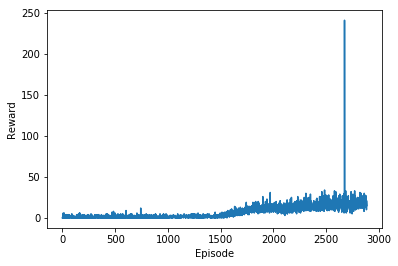

In [12]:
#Plot reward per episode
plt.plot(reward_sums)
plt.ylabel('Reward')
plt.xlabel('Episode')

Text(0.5, 0, 'Epoch (10 Episodes)')

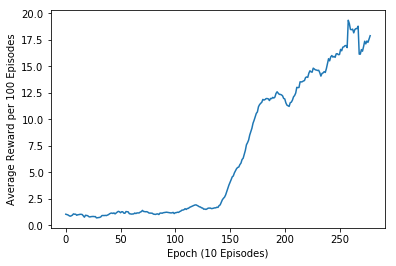

In [13]:
# Plot average reward
reward_sums_av = []
for i in range(0,len(reward_sums)-100,10):
    reward_sums_av.append(sum(reward_sums[i:i+100])/100)
    
plt.plot(reward_sums_av)
plt.ylabel('Average Reward per 100 Episodes')
plt.xlabel('Epoch (10 Episodes)')

In [20]:
# Play Breakout using learnt agent
terminal =  False
state = env_wrap.reset()
total_reward = 0.0
num_actions = 0

while not terminal:
    
    action = agent.epsilon_greedy_action( torch.from_numpy(state).float().view(-1,4,80,80).cuda() , 0.01)
    next_state, reward, terminal, _ = env_wrap.step(action)
    num_actions += 1
    total_reward += reward
    state = next_state
    time.sleep(0.05)
    env_wrap.render()

In [21]:
print(num_actions, total_reward)

1464 24.0
